## Notes
This notebook
- calculates $\rho_v(r)$, $\rho_v^{\parallel}(r)$, $\rho_v^{\perp}(r)$
- plots $P(v_1, v_2)$
- plots $P(v_1^2, v_2^2)$
- compares PDFs with and without anisotropic correction

To do:
- Shape of PDF looks ok (?)
- Doesn't integrate to 1
- Still need to fix ringing at beginning
- Extremely small values when subbing in same $\rho$ values
- After fixing previous issue, need to check if subbing in $\rho_v$ gives same result as isotropic PDF derived from different coordinates
- Use smoothing?
- Look into the invalid value and overflow errors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import zeus21
from scipy.integrate import simpson
from scipy.special import i0
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "notebook"

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

## `Zeus` setup

In [4]:
UserParams = zeus21.User_Parameters(precisionboost=2)
CosmoParams_input = zeus21.Cosmo_Parameters_Input(kmax_CLASS=1000., USE_RELATIVE_VELOCITIES=True)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(UserParams, CosmoParams_input, ClassyCosmo) 
CorrFClass = zeus21.Correlations(UserParams, CosmoParams, ClassyCosmo)

## Compute correlations

Find 8 Mpc smoothing radius in case we want to use it:

In [5]:
idx_smooth = 30
CosmoParams._Rtabsmoo[idx_smooth] # approx 8 Mpc

np.float64(8.187428672251672)

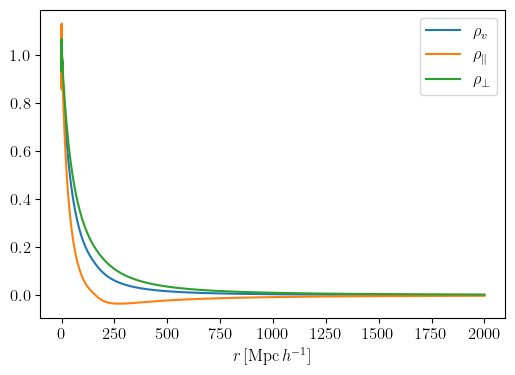

In [6]:
CF_v = CorrFClass.xi_RR_CF_v
CF_para = CorrFClass.xi_RR_CF_para
CF_perp = CorrFClass.xi_RR_CF_perp
r_list = CorrFClass.rlist_CF
sigma_v = CorrFClass.sigma_v[0, 0] # No smoothing

CF_v = CF_v[0, 0, :] # No smoothing
CF_para = CF_para[0, 0, :] # No smoothing
CF_perp = CF_perp[0, 0, :] # No smoothing

vbarsq = sigma_v**2
rho_v = CF_v / 3 / vbarsq
rho_para = CF_para / vbarsq
rho_perp = CF_perp / vbarsq

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(r_list, rho_v, label=r'$\rho_v$')
ax.plot(r_list, rho_para, label=r'$\rho_\parallel$')
ax.plot(r_list, rho_perp, label=r'$\rho_\perp$')
ax.set_xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
ax.legend()

As a temporary measure, we cut off the ringing part at the beginning, which would cause some $\rho$ values to be out of range. We don't lose much r range practically, since `r_list` is log spaced.

Text(0.5, 1.0, '$\\rho$ values no longer exceed 1')

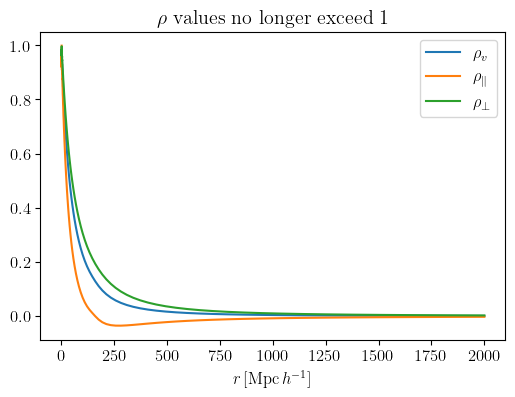

In [7]:
rho_v_mod = rho_v[16:]
rho_para_mod = rho_para[16:]
rho_perp_mod = rho_perp[16:]
r_list_mod = r_list[16:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(r_list_mod, rho_v_mod, label=r'$\rho_v$')
ax.plot(r_list_mod, rho_para_mod, label=r'$\rho_\parallel$')
ax.plot(r_list_mod, rho_perp_mod, label=r'$\rho_\perp$')
ax.set_xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')
ax.legend()
ax.set_title(r'$\rho$ values no longer exceed 1')

## PDF definitions

In [8]:
def prefactor_N(vbarsq, rho_para, rho_perp):
    return (2 * np.pi * vbarsq)**3 * np.sqrt(1 - rho_para**2) * (1 - rho_perp**2)

def P_v_v(vbarsq, rho_para, rho_perp, v_1, v_2):
    '''
    Joint PDF of velocities v_1 and v_2.
    6 dimensional input seems like a handful.
    vbarsq is scalar.
    rho_para and rho_perp must have the same length (currently only support 1 dimension).
    v_1 and v_2 are 3D vectors, must have shape (n, 3).
    Not currently used
    '''
    N = prefactor_N(vbarsq, rho_para, rho_perp)

    # Broadcast to shape: (n_r, n_v, 3)
    N_bcast = N[:, np.newaxis, np.newaxis]
    rho_para_bcast = rho_para[:, np.newaxis, np.newaxis]
    rho_perp_bcast = rho_perp[:, np.newaxis, np.newaxis]
    v_1_bcast = v_1[np.newaxis, :, :]
    v_2_bcast = v_2[np.newaxis, :, :]

    v_1_perp = v_1_bcast[:, :, 0:1]
    v_2_perp = v_2_bcast[:, :, 0:1]
    v_1_z = v_1_bcast[:, :, 2]
    v_2_z = v_2_bcast[:, :, 2]

    exponent = - 1 / (2 * vbarsq) * (
                                    (v_1_z**2 + v_2_z**2 - 2 * rho_para_bcast * v_1_z * v_2_z) / (1 - rho_para_bcast**2) + 
                                    (v_1_perp**2 + v_2_perp**2 - 2 * rho_perp_bcast * np.inner(v_1_perp, v_2_perp)) / (1 - rho_perp_bcast**2)
                                    )
    return 1 / N_bcast * np.exp(exponent)

def P_X_Y(X, Y, vbarsq, rho_para, rho_perp, n_points=100):
    '''
    Joint PDF of X=v_1**2 and Y=v_2**2.
    vbarsq is scalar.
    rho_para and rho_perp must have the same length (currently only support 1 dimension)
    '''
    rho_para = np.array([rho_para]) if np.isscalar(rho_para) else np.array(rho_para)
    rho_perp = np.array([rho_perp]) if np.isscalar(rho_perp) else np.array(rho_perp)
    X = np.array([X]) if np.isscalar(X) else np.array(X)
    Y = np.array([Y]) if np.isscalar(Y) else np.array(Y)

    vbarsq = np.full_like(rho_para, vbarsq) # currently limited to scalar value vbarsq

    sqrtX = np.sqrt(X)
    sqrtY = np.sqrt(Y)

    # n_r is the length of r_list, vbarsq, rho_para, and rho_perp
    n_r, n_X, n_Y = len(vbarsq), len(X), len(Y)

    result = np.zeros((n_r, n_X, n_Y))

    # Loop over X and Y (needed due to different integration bounds)
    # But vectorize over r dimension
    for j in range(len(X)):
        for k in range(len(Y)):
            v_1_z_arr = np.linspace(-0.999*sqrtX[j], 0.999*sqrtX[j], n_points)
            v_2_z_arr = np.linspace(-0.999*sqrtY[k], 0.999*sqrtY[k], n_points)

            v_1_z_mesh, v_2_z_mesh = np.meshgrid(v_1_z_arr, v_2_z_arr, indexing='ij')
            X_arr = np.full_like(v_1_z_mesh, X[j])
            Y_arr = np.full_like(v_2_z_mesh, Y[k])

            # Broadcast to shape: (n_r, n_points, n_points)
            vbarsq_grid = vbarsq[:, np.newaxis, np.newaxis]
            rho_para_grid = rho_para[:, np.newaxis, np.newaxis]
            rho_perp_grid = rho_perp[:, np.newaxis, np.newaxis]
            v_1_z_grid = v_1_z_mesh[np.newaxis, :, :]
            v_2_z_grid = v_2_z_mesh[np.newaxis, :, :]
            X_grid = X_arr[np.newaxis, :, :]
            Y_grid = Y_arr[np.newaxis, :, :]

            # Compute prefactor
            N = prefactor_N(vbarsq, rho_para, rho_perp)
            prefactor = np.pi / N * np.exp(- (X[j] + Y[k]) / (2 * vbarsq * (1 - rho_perp**2)))

            # Compute integrand
            integrand_exp = - 1 / (2 * vbarsq_grid) * (
                                        (rho_para_grid**2 - rho_perp_grid**2) * (v_1_z_grid**2 + v_2_z_grid**2) / ((1 - rho_para_grid**2) * (1 - rho_perp_grid**2)) - 
                                        2 * rho_para_grid * v_1_z_grid * v_2_z_grid / (1 - rho_para_grid**2)
                                        )
            argument = rho_perp_grid * np.sqrt(X_grid - v_1_z_grid**2) * np.sqrt(Y_grid - v_2_z_grid**2) / (vbarsq_grid * (1 - rho_perp_grid**2))
            integrand_I0 = i0(argument)

            # Integrate
            integral_v2 = simpson(integrand_exp * integrand_I0, x=v_2_z_arr)
            integral_v1_v2 = simpson(integral_v2, x=v_1_z_arr)

            result[:, j, k] = prefactor * integral_v1_v2

    return result

## Plot PDF

In [9]:
X_arr = np.linspace(0.1, 1e6, 30)
Y_arr = np.linspace(0.1, 1e6, 30)

P_X_Y_arr = P_X_Y(X_arr, Y_arr, vbarsq, rho_para_mod, rho_perp_mod)

/Users/yuranzhang/Desktop/untitled folder 5/marc/Zeus21/venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:368: RuntimeWarning:

overflow encountered in multiply

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_1062/3245469531.py:90: RuntimeWarning:

invalid value encountered in multiply

/Users/yuranzhang/Desktop/untitled folder 5/marc/Zeus21/venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:372: RuntimeWarning:

overflow encountered in multiply

/Users/yuranzhang/Desktop/untitled folder 5/marc/Zeus21/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning:

overflow encountered in reduce

/Users/yuranzhang/Desktop/untitled folder 5/marc/Zeus21/venv/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:368: RuntimeWarning:

overflow encountered in add

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_1062/3245469531.py:87: RuntimeWarning:

overflow encountered in multiply



In [10]:
fig = go.Figure()

# Add surfaces for each r value (first index)
n_r = P_X_Y_arr.shape[0]
for i in range(n_r):
    fig.add_trace(
        go.Surface(
            z=P_X_Y_arr[i, :, :],
            x=X_arr,
            y=Y_arr,
            visible=(i == 0),  # Only show the first one initially (not working for some reason)
            name=f'r = {r_list_mod[i]:.1f} Mpc/h'
        )
    )

# Create slider steps
steps = []
for i in range(n_r):
    step = dict(
        method="update",
        args=[{"visible": [False] * n_r}],  # Hide all traces
        label=f'{r_list_mod[i]:.1f}'
    )
    step["args"][0]["visible"][i] = True  # Show only the i-th trace
    steps.append(step)

# Add slider
sliders = [dict(
    active=n_r-1,  # Start with the last index
    currentvalue={"prefix": "r = ", "suffix": " Mpc/h"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='Joint PDF for velocity² with anisotropic correlations',
    scene=dict(
        xaxis_title='X= v₁²[km²h⁻²s⁻²]',
        yaxis_title='Y= v₂²[km²h⁻²s⁻²]',
        zaxis_title='P(X, Y)'
    ),
    sliders=sliders
)

fig.show()

In [11]:
P_X_Y_temp = P_X_Y_arr[14, :, :]
simpson(simpson(P_X_Y_temp, x=X_arr), x=Y_arr)

np.float64(0.044954320379475006)

### Difference between isotropic and anisotropic

In [12]:
P_X_Y_iso_arr = P_X_Y(X_arr, Y_arr, vbarsq, rho_v_mod, rho_v_mod)
P_X_Y_diff_arr = P_X_Y_arr - P_X_Y_iso_arr

In [13]:
fig = go.Figure()

# Add surfaces for each r value (first index)
n_r = P_X_Y_diff_arr.shape[0]
for i in range(n_r):
    fig.add_trace(
        go.Surface(
            z=P_X_Y_iso_arr[i, :, :],
            x=X_arr,
            y=Y_arr,
            visible=(i == 0),  # Only show the first one initially
            name=f'r = {r_list_mod[i]:.1f} Mpc/h'
        )
    )

# Create slider steps
steps = []
for i in range(n_r):
    step = dict(
        method="update",
        args=[{"visible": [False] * n_r}],  # Hide all traces
        label=f'{r_list_mod[i]:.1f}'
    )
    step["args"][0]["visible"][i] = True  # Show only the i-th trace
    steps.append(step)

# Add slider
sliders = [dict(
    active=n_r-1,  # Start with the last index
    currentvalue={"prefix": "r = ", "suffix": " Mpc/h"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='Difference between isotropic and anisotropic P(X, Y)',
    scene=dict(
        xaxis_title='X= v₁²[km²h⁻²s⁻²]',
        yaxis_title='Y= v₂²[km²h⁻²s⁻²]',
        zaxis_title='P(X, Y)'
    ),
    sliders=sliders
)

fig.show()

In [14]:
P_X_Y_frac_arr = P_X_Y_diff_arr / P_X_Y_iso_arr

In [15]:
fig = go.Figure()

# Add surfaces for each r value (first index)
n_r = P_X_Y_frac_arr.shape[0]
for i in range(n_r):
    fig.add_trace(
        go.Surface(
            z=P_X_Y_frac_arr[i, :, :],
            x=X_arr,
            y=Y_arr,
            visible=(i == 0),  # Only show the first one initially
            name=f'r = {r_list_mod[i]:.1f} Mpc/h'
        )
    )

# Create slider steps
steps = []
for i in range(n_r):
    step = dict(
        method="update",
        args=[{"visible": [False] * n_r}],  # Hide all traces
        label=f'{r_list_mod[i]:.1f}'
    )
    step["args"][0]["visible"][i] = True  # Show only the i-th trace
    steps.append(step)

# Add slider
sliders = [dict(
    active=n_r-1,  # Start with the last index
    currentvalue={"prefix": "r = ", "suffix": " Mpc/h"},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title='Fractional difference between isotropic and anisotropic P(X, Y)',
    scene=dict(
        xaxis_title='X= v₁²[km²h⁻²s⁻²]',
        yaxis_title='Y= v₂²[km²h⁻²s⁻²]',
        zaxis_title='P(X, Y)'
    ),
    sliders=sliders
)

fig.show()